
# Demo of Causal Representation Learning (CRL) 
    by Jia Li jiaxx213@umn.edu 
    project finished in Aug 2022, published Feb 2023


In [1]:
import numpy as np
import tensorflow as tf
from os.path import exists
tf.compat.v1.enable_eager_execution()
#from tensorflow.keras import initializers
from datetime import datetime
from time import sleep
import code_load_data as dt
dt.verb = 2
import code_init_tower as tw
import code_train_graph as gp

#import pandas as pd
import os,sys

2023-02-13 16:22:05.592235: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 16:22:05.592283: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


This demo is to realize a causal discovery in latent representation feature space, based on hydrology dataset
 * code_load_data: processing .csv data files to save as obj_data.pickle; will execute the data processing if .pickle not exists.
 * code_init_tower: the special autoencoder for higher-dimensional representation extraction
 * code_bicross_extractor: the originally designed layers Encrypt and Decrypt
 * code_build_unit: causal effect learning (by RNN-GRU) in latent space between two autoencoders (i.e., towers), saved as a unit.
 * code_train_graph: modeling the entire causal graph in latent space; manage the processes of building towers (graph vertics), units (graph edges), and causal structual discovery based on these towers and units. An established graph model is saved as a predictor.
 * code_display_graph: responsible for showing required performances, including both text summary and figure displaying.

In [2]:
#---
data_obj = dt.Data_Store()
data_obj.load()
graph_obj = dt.Graph_Obj(data_obj)
manager = gp.Preserve_Manager(graph_obj, data_obj)
manager.load()
sleep(2)
# ----- Tower -----
manager.complete_tower()
n_run = len(manager.tw_tasks_run)
now = datetime.now()
time_stamp = now.strftime("%m/%d %H:%M:%S")
if n_run > 0:
    print(time_stamp+" [Main_Run][Discover-Tower] initial towers unfinished: "+', '.join(manager.tw_tasks_run))
else:
    print(time_stamp+" [Main_Run][Discover-Tower] all initial towers finished.")

[Data_Store] loading saved data.
[Graph_Obj] creating...
[Preserve_Manager] created


/home/kumarbio/jiaxx213/anaconda3/envs/tf115/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2023-02-13 16:22:10.928910: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-13 16:22:10.929295: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-13 16:22:10.929326: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-13 16:22:10.929378: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel

[Show Box] display single tower
    x_mean  x_std   x_min   x_max   exp_max | recv    orig    mask  |  EP   ep   STATUS
j    0.0410  0.2     0.0     7.8903  53.930    0.007   0.098   1.088   16    1     done  
g    0.7180  1.1064  0.0     8.2551  64.849    0.045   0.81    1.327   72    2     done  
h    0.7344  1.0193  0.0     7.6350  47.403    0.045   0.009   1.345   44    1     done  
i    0.1432  0.6137  0.0     8.3880  69.356    0.035   0.009   1.672   1     1     done  
c    1.0342  1.0025  0.0     6.2145  23.121    0.037   0.089   0.428   46    19    done  
d    0.0458  0.2005  0.0     5.2434  14.153    0.015   0.679   0.445   11    1     done  
e    3.1449  1.0     0.0285  5.0916  13.108    0.058   3.343   0.643   72    2     done  
f    0.3922  0.8962  0.0     8.6122  77.676    0.326   7.178   2.045   12    2     done  
b    1.5531  1.5660  -3.355  7.6809  48.514    0.076   0.678   1.132   81    1     done  
[Show Box] display full tower
    x_mean  x_std   x_min   x_max   exp_

# effects learning
The graph G contains 10 nodes, so 10 towers are built accordingly as above.
The effects learninig (remarked as [Discover-Backprob]) includes three stages to establish: single, full, and multi units, respectively.
Unfinished but required units will be output as commands written in corresponding CMDbuffer files.
* single unit: the one-to-one causations, e.g., nodes A, B, and C cause D, then there're 3 single units A->D, B->D, and C->D
* full unit: the multi-to-one causation with all causes, e.g., for node D there's 1 full unit ABC->D
* multi unit: the multi-to-one causations with combinational causes on demand, which is determined by discovery process, e.g., AB->D

In [3]:
# ----- Backprob -----
manager.complete_backprob() # full and single tasks
def count_dict(in_dict):
    norun_set = in_dict["null"] + in_dict["ready"]
    run_set = in_dict["run"]
    n_all = len(norun_set)+len(run_set)+len(in_dict["done"])
    return len(norun_set), len(run_set), n_all

now = datetime.now()
time_stamp = now.strftime("%m/%d %H:%M:%S")
full_res = count_dict(manager.u_obj.full_dict)
n_full_wait = sum(full_res[:2])
if not n_full_wait==0:
    print(time_stamp+" [Main_Run][Discover-Backprob] full causes units: "+str(n_full_wait)+"/"+str(full_res[2])+" unfinished.")
    
manager.show_box.display_evals(manager.u_obj.full_set, manager.u_obj.full_dict, "unit", "full")
# ---
single_res = count_dict(manager.u_obj.single_dict)
n_single_wait = sum(single_res[:2])
if not n_single_wait==0:
    print(time_stamp+" [Main_Run][Discover-Backprob] single causes units: "+str(n_single_wait)+"/"+str(single_res[2])+" unfinished.")

manager.show_box.display_evals(manager.u_obj.single_set, manager.u_obj.single_dict,"unit", "single")
# ---
multi_res = count_dict(manager.u_obj.multi_dict)
n_multi_wait = sum(multi_res[:2])
if not n_multi_wait==0:
    print(time_stamp+" [Main_Run][Discover-Backprob] multi causes units: "+str(n_multi_wait)+"/"+str(multi_res[2])+" unfinished.")

manager.show_box.display_evals(manager.u_obj.multi_set, manager.u_obj.multi_dict,"unit", "multi")
print("[Reimnder] for multi, null/ready = not demanded")

if n_full_wait==0 and n_single_wait==0:
    print(time_stamp+" [Main_Run][Discover-Backprob] all full & single causes units done.")

--- 02/13 16:22:12 ---
[Preserve_Manager] backprob renewal done.
    done tasks: ghi_j, cde_g, de_h, df_i, a_c, bc_d, bc_e, e_f, g_j, h_j, i_j, c_g, d_g, e_g, d_h, e_h, d_i, f_i, b_d, c_d, b_e, c_e
    running tasks: 
    ready tasks: 
    no-run tasks: 
[Show Box] display full unit
       recv    recv_B  recv_tw | orig    orig_B  orig_tw | mask    mask_B  mask_tw | recv_A  recv_tw_A  | KLD  | EP   ep   STATUS
ghi_j  0.0090  0.0052  0.007     0.1269  0.0742  0.098     0.2937  0.2593  1.088     0.0386  0.049       5.5300  20    6     done  
cde_g  0.1719  0.0538  0.045     3.5736  0.9598  0.81      0.1340  0.0878  1.327     0.0374  0.042       8.1360  25    6     done  
de_h   0.3564  0.0889  0.045     0.0096  0.0099  0.009     2.5980  2.5980  1.345     0.0347  0.034       21.905  21    6     done  
df_i   0.1158  0.0600  0.035     0.0099  0.0103  0.009     3.4493  3.4493  1.672     0.2536  8.085       49.033  12    6     done  
a_c    0.1747  0.0295  0.037     0.3334  0.0616  0.089    

# discovery process
Causal discovery (remarked as [Discover-Forward]) requires all single-units and full-units finished, and in the process will instantly output the commands for demanded multi-units, whose unknown effects will be estimated by average temporally in the current process.
The discovery process should be repeated untill no further demangded multi-units output.
The discovery results will be auto-saved in obj_manager.pickle.

In [4]:

# # ----- Forward -----
now = datetime.now()
time_stamp = now.strftime("%m/%d %H:%M:%S")
sleep(2)
fw_tag = manager.run_forward()
manager.save()
if not fw_tag:
    print(time_stamp +" [Main_Run][Discover-Forward] failed! ")
else:
    print(time_stamp+" [Main_Run][Discover-Forward] all multi causes units done.")



#manager.build_predicter()

#manager.build_predicter(if_refine=True)
#manager.refnr.reset_all()

[Preserve_Manager] start forward discovery. 
  # Round 1:
    Candid: (a_c)7.6354 (a_d)19.7407 (a_e)60.1876 (a_f)119.7730 (b_c)8.4753 (b_d)8.5147 (b_e)37.6500 (b_f)101.3770 
    Select: (a_c)7.6354
    Trimmed: (b_c)8.4753 
  # Round 2:
    Candid: (a_d)19.7407 (a_e)60.1876 (a_f)119.7730 (b_d)8.5147 (b_e)37.6500 (b_f)101.3770 (c_d)10.1490 (c_e)46.5876 
            (c_f)111.2978 (c_g)11.6012 (c_h)39.2361 (c_i)95.1564 
    Select: (b_d)8.5147
    Trimmed: 
  # Round 3:
    Candid: (a_d)9.7357 (a_e)60.1876 (a_f)119.7730 (b_e)37.6500 (b_f)101.3770 (c_d)1.1355 (c_e)46.5876 (c_f)111.2978 
            (c_g)11.6012 (c_h)39.2361 (c_i)95.1564 (d_e)32.3401 (d_f)91.9256 (d_g)27.8798 (d_h)25.1988 (d_i)75.5775 
    Select: (c_d)1.1355
    Trimmed: (a_d)9.7357 
  # Round 4:
    Candid: (a_e)60.1876 (a_f)119.7730 (b_e)37.6500 (b_f)101.3770 (c_e)46.5876 (c_f)111.2978 (c_g)11.6012 (c_h)39.2361 
            (c_i)95.1564 (d_e)32.3401 (d_f)91.9256 (d_g)27.8798 (d_h)25.1988 (d_i)75.5775 
    Select: (c_g)11

# construct the complete graphical model
This step aims to build up a complete structural model for causal graph G, such that the causation from any cause node toward any result node can be estimated along a predictive routine, which is determined by the causal discovery results above.
Particularly, the single units, AKA the pair-wise direct causal effects, have been in a sequence by their detected order in causal discovery, and stacking them one by one by following this sequence can construct a complete graphical model.
The object for this job is named "predictor", created and managed by the established "manager", where differently ordering stacked edges can define different predictors and registered to the same manager. In this demo, only one predictor exists. Tasks of a predictor include:
* Establish a set of training units (differetiated from the single/full/multi units used in discovery process), such that for each node in G, all its possible predictive routines have been established as corresponding training units. For example, since A and B are both resource nodes, the routines for node J have three possible ones: a_c_g_j, b_d_h_j, and b_e_f_i_j.
* Training the set of units one by one. For each unit, only the top layer of the stacked effects are trained and all the under effects have been trained in previous units. For example, the unit a_c_g_j only trains the effect G->J by adopting trained weights in unit a_c_g. All weights are initialized from the existing discovery units, and thus the entrance units do not need training.
* Output the predicted results of test data. The training data used in above processes is for the 60 years 1902-1961, and the test data is the following 60 years 1962-2022. If some units training are not done yet, the prediction cannot perform and required shell commands for the remaining trainings will be autometically updated to file CMDbuffer_train.txt.

In [5]:
manager.build_predicter()

[Predicter] ab=>j Created
[Predicter][ab~j] a=>c entrances initialized.
[Predicter][ab~j] b=>d entrances initialized.
[Predicter][ab~j] c=>d loading unit c_d
[Predicter][ab~j] c=>g loading unit c_g
[Predicter][ab~j] d=>g loading unit d_g
[Predicter][ab~j] d=>h loading unit d_h
[Predicter][ab~j] b=>e entrances initialized.
[Predicter][ab~j] c=>e loading unit c_e
[Predicter][ab~j] e=>g loading unit e_g
[Predicter][ab~j] g=>j loading unit g_j
[Predicter][ab~j] e=>h loading unit e_h
[Predicter][ab~j] h=>j loading unit h_j
[Predicter][ab~j] e=>f loading unit e_f
[Predicter][ab~j] f=>i loading unit f_i
[Predicter][ab~j] d=>i loading unit d_i
[Predicter][ab~j] i=>j loading unit i_j
[Predicter][ab~j] Ready.
        [0]a_c(T) [1]b_d(T) [2]c_d(T) [3]c_g(T) [4]d_g(T) [5]d_h(T)
        [6]b_e(T) [7]c_e(T) [8]e_g(T) [9]g_j(T) [10]e_h(T) [11]h_j(T)
        [12]e_f(T) [13]f_i(T) [14]d_i(T) [15]i_j(T)
[Predicter][ab~j] Done Units: a_c, b_d, a_c_d, a_c_g, b_d_g, b_d_h, b_e, a_c_e, b_e_g, a_c_g_j, b_e_h

# performance comparision by result figures
The published paper referring to this demo only contains the results of Discovery learning stage, because of the space limit as a conference paper. Here we provide results of all the three learning stages (Discovery, Training, and Predicting). The explanations of the figure output parameters are as below:
* node_key_arr = ['j','g','i']: required argument, to show multiple result nodes by different rows.
* yr_idx = 10: optional argument with 0 as default, to specify index of displaying year. The 10th year for discovery and training is 1912 and for prediction is 1972.
* eval_idx = 2: optional argument with 0 as default, the index of selected column to display for each node, ordered by these columns' training evaluations from the worst to the best. By default 0, the worst reconstructed column will be selected for each node.
* stages_tag=[True,True,False]: optional argument with default setting [True,False,True], to specify whether displaying the three stages, Discovery, Training, and Predicting, respectively. Each stage occupies one column of the figures, thus suggest not to exceed two stages.
* legends in figure: The black dots are ground truth observations, and the blue lines remarked as [Repre] are showing the autoencoder reconstruction results. In [Discv] stage, all displayed units are in one hop, remarked as [set of causes_result node], e.g., [GHI_J] means the discovery unit with simultaneously input values from cause nodes G, H, and I, to estimate value of the result node J. In [Train] and [Pred] stages, units are in multiple hops comprising the predictive routine, e.g., [ACG_J] means the causal estimation from A to J through the routine a_c_g_j.

[Show Box] figure node = N9_j_Q, the No.1 worst column.(1 column(s) in total))
           training years 1902-1962
           column names: Q_pred
           column order: 0
           tower Scaled Value rmse = 0.006
[Show Box] figure node = N6_g_SR, the No.3 worst column.(4 column(s) in total))
           training years 1902-1962
           column names: SURQ_0, SURQ_1, SURQ_2, SURQ_3
           column order: 0, 1, 3, 2
           tower Scaled Value rmse = 0.045
[Show Box] figure node = N8_i_BF, the No.3 worst column.(3 column(s) in total))
           training years 1902-1962
           column names: GW_0, GW_1, GW_2
           column order: 0, 1, 2
           tower Scaled Value rmse = 0.050


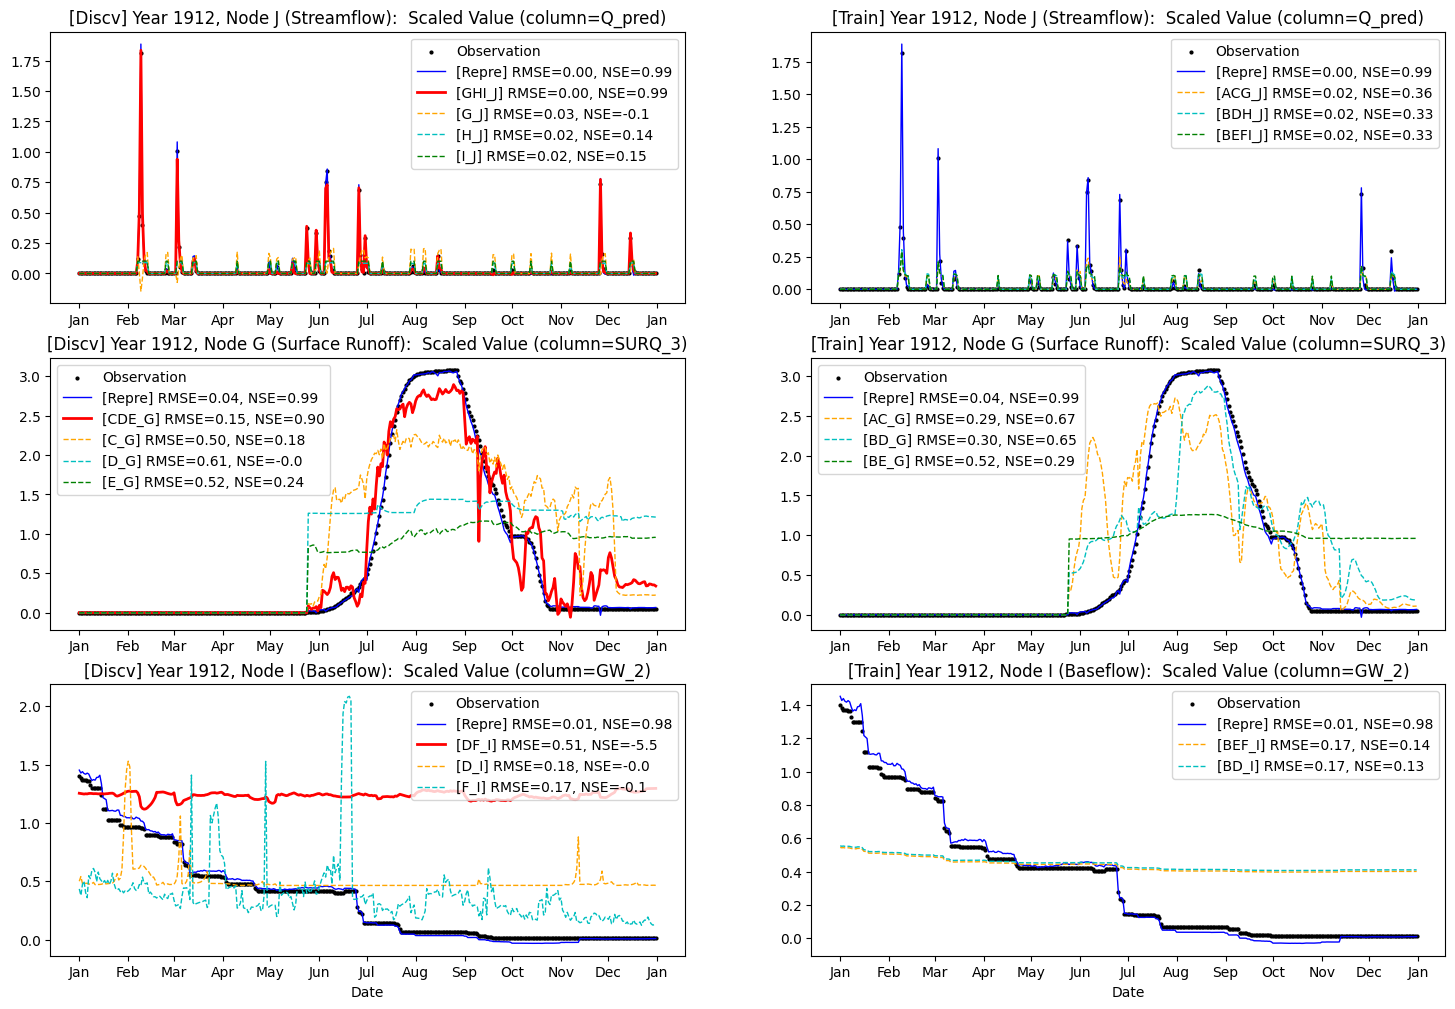

In [11]:
manager.show_box.fig_outputs_compact(['j','g','i'], yr_idx=10, eval_idx=2, stages_tag=[True,True,False])

In [7]:
# import code_build_unit as un
# done_arr = ["b_e"]
# for task in done_arr:
#     causes_keys_str, node_key = task.split('_')
#     causes_keys = [char for char in causes_keys_str]
#     fname_set = dt.get_discv_unit_fnames(node_key, causes_keys, False)
#     new_unit = un.Preserve_Unit(node_key, causes_keys, data_obj, fname_set)
#     new_unit.reset_running()
#     print("Debug: unit " + task + " done.")